# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
def mean_absolute_error(Y_true, Y_pred, axis=0):
    return np.mean(np.abs(Y_true - Y_pred), axis=axis)

def mean_squared_error(Y_true, Y_pred, squared=True, axis=0):
    res =  np.mean(np.power(Y_true - Y_pred, 2), axis=axis)
    if not squared:
        return np.sqrt(res)
    return res

In [3]:
import option 

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
delta = 0.03
S_max = 2
S_min = 0
S_test = np.arange(S_min, S_max, step=0.2)

# Front fixing method

## Inverse transformation

### Explicit


##### Space

In [4]:
from frontfixing import nielsen
dx = [1/64, 1/128, 1/256, 1/512]
dt = 0.5*dx[-1]**2
V_pred = []
for i, dx_i in enumerate(dx):
    S, V, S_bar = nielsen.solve_explicitly(put, r, sigma, x_max=2, dx=dx_i, dt=dt, delta=delta)
    V_pred.append(V[:])

[0.003322024558233161, 0.001652238161651387, 0.000823300668229443]
[ 1.00628572 -1.52246938]


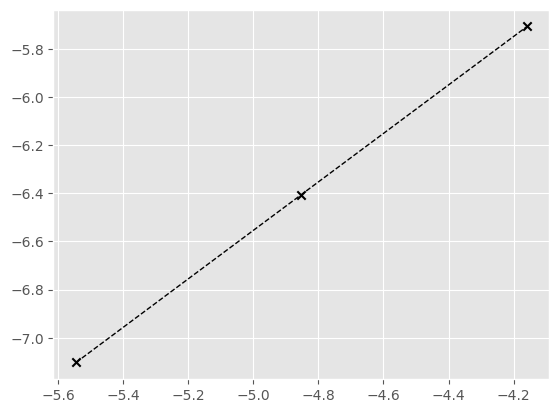

In [5]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
print(error)
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

##### Time

In [6]:
dx = 1/128
dt = 0.5*np.power([1/128, 1/256, 1/512, 1/1024],2)
V_pred = []
for i, dt_i in enumerate(dt):
    S, V, S_bar = nielsen.solve_explicitly(put, r, sigma, x_max=3, dx=dx, dt=dt_i,delta=delta)
    V_pred.append(V[:])

[ 0.99973989 -1.84992442]


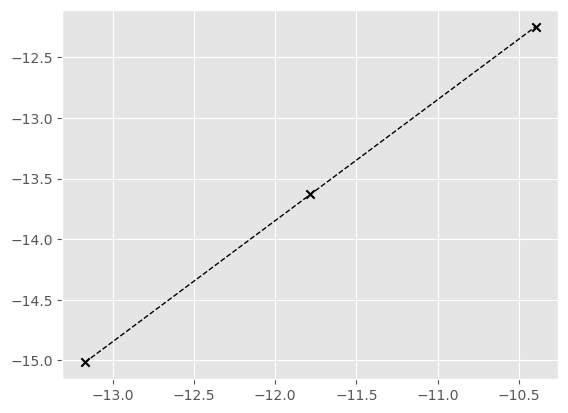

In [7]:
error = []
for i in range(len(dt)-1):
    error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)

### Implicit

#### Space

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from frontfixing import nielsen
import option

dx = [1/128, 1/256, 1/512, 1/1024]
dt = 1/1024

V_pred = []
for i, dx_i in enumerate(dx):
    print("iteration", i)
    S, V, S_bar = nielsen.solve_implicitly(put, r, sigma, x_max=2, dx=dx_i, dt=dt, delta=delta, tolerance=1e-21, maxiter=10*6)
    print(S_bar)
    V_pred.append(V[:])


iteration 0
0.8360826033186647
iteration 1
0.837705711292478
iteration 2
0.8385219607867711
iteration 3
0.8389302917528609


[ 0.99547405 -1.59246494]


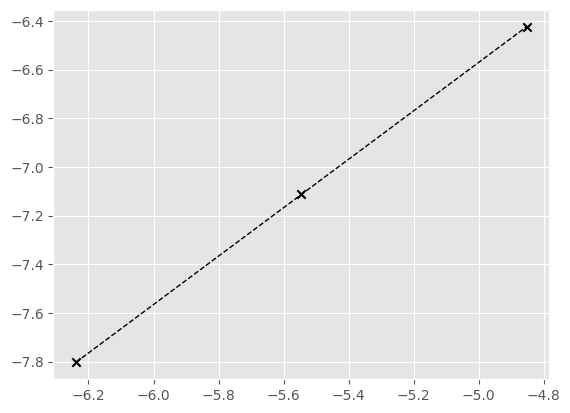

In [9]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

#### Time

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from frontfixing import nielsen
import option

dx = 1/32
dt = [1/128, 1/256, 1/512, 1/1024]

V_pred = []
for i, dt_i in enumerate(dt):
    print("iteration", i)
    S, V, S_bar = nielsen.solve_implicitly(put, r, sigma, x_max=2, dx=dx, dt=dt_i, delta=delta, tolerance=1e-24, maxiter=10)
    V_pred.append(V[:])

iteration 0
iteration 1
iteration 2
iteration 3


[ 0.94918564 -3.2602999 ]


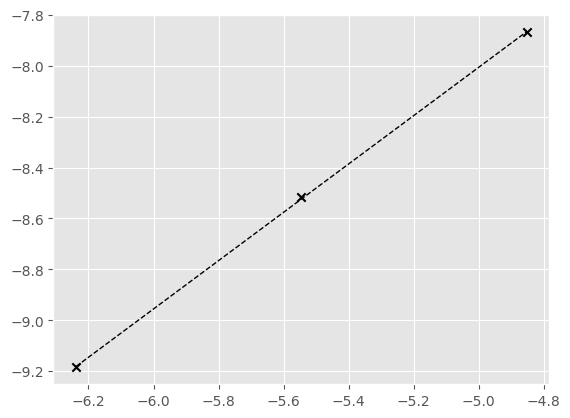

In [11]:
error = []
for i in range(len(dt)-1):
    error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)

## Company transformation

### Explicit

#### Space

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from frontfixing import company
import option

dx = [1/128, 1/256, 1/512, 1/1024]
dt = 0.5*dx[-1]**2

V_pred = []
for i, dx_i in enumerate(dx):
    S, V, S_bar = company.solve_explicitly(put, r, sigma, x_max=2, dx=dx_i, dt=dt, delta=delta)
    V_pred.append(np.array(V[:]))

[6.190469145897146e-06, 1.8382891043677158e-06, 5.342777182719416e-07]
[ 1.7671935  -3.41444015]


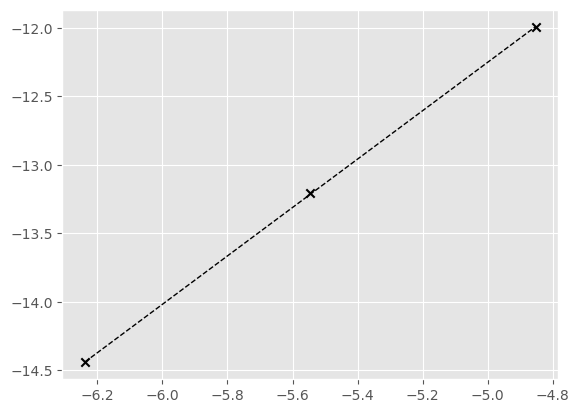

In [13]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
print(error)
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

#### Time

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from frontfixing import company
import option

dx = 1/128
dt = 0.5*np.array([1/128, 1/256, 1/512, 1/1024])**2

r = 0.1
sigma = 0.2
T = 1
K = 1
put = option.put(K, T)

V_pred = []
for i, dt_i in enumerate(dt):
    S, V, S_bar = company.solve_explicitly(put, r, sigma, x_max=3, dx=dx, dt=dt_i)
    V_pred.append(V[:])

[ 0.99936876 -2.39478516]


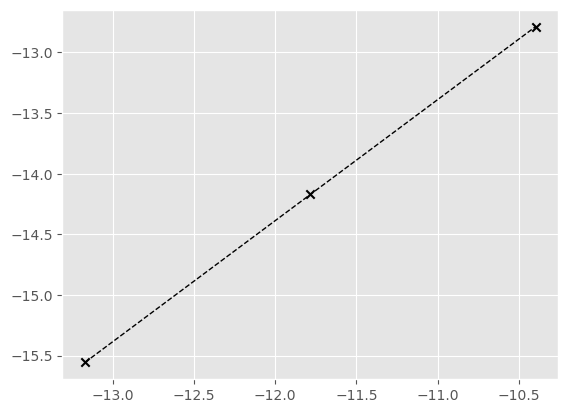

In [15]:
error = []
for i in range(len(dt)-1):
    error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)

# LCP + PSOR

## Explicit

### Space

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = [1/16, 1/32, 1/64, 1/128]
dt = 0.5*dx[-1]**2

V_pred = []
for i, dx_i in enumerate(dx):
    S, V = lcp.solve(put, r, sigma, x_max=2, dx=dx_i, dt=dt, delta=delta, theta=0)
    V_pred.append(V[:])

[0.0007868474936200132, 0.0002892073505194326, 4.353387698832062e-05]
[ 2.08793681 -1.20970039]


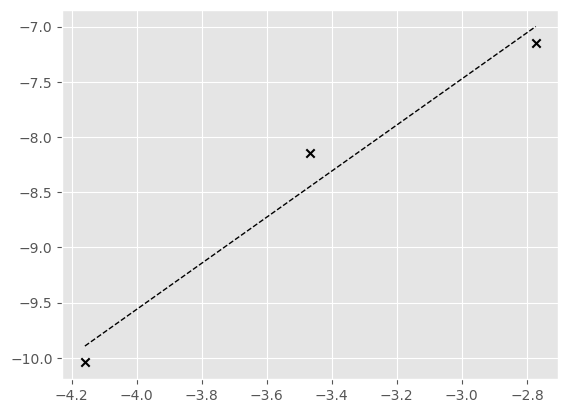

In [17]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
print(error)
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

#### Time

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = 1/32
dt = 0.5*np.array([1/32, 1/64, 1/128, 1/256])**2

V_pred = []
for i, dt_i in enumerate(dt):
    S, V = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, theta=0, delta=delta)
    V_pred.append(V[:])

[ 1.00122351 -6.49815071]


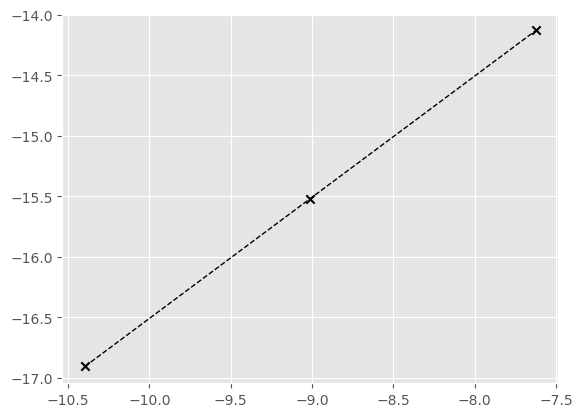

In [19]:
error = []
for i in range(len(dt)-1):
    error.append(np.abs(dx*np.sum(V_pred[i+1]) - dx*np.sum(V_pred[i])))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)

## Implicit

#### Space

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = [1/16, 1/32, 1/64, 1/128]
dt = 1/4

V_pred = []
for i, dx_i in enumerate(dx):
    S, V = lcp.solve(put, r, sigma, dx=dx_i, dt=dt, delta=delta, theta=1)
    V_pred.append(V[:])

[0.0007461820504497535, 0.00033551918477417453, 4.002193026093198e-05]
[ 2.1103325  -1.12829668]


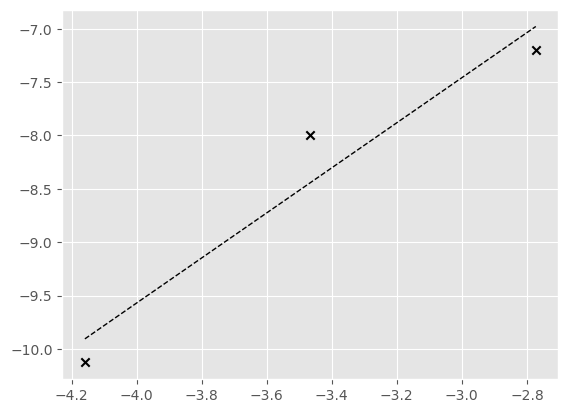

In [21]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
print(error)
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

#### Time

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = 1/16
dt = [1/32, 1/64, 1/128, 1/256]

V_pred = []
for i, dt_i in enumerate(dt):
    S, V = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, delta=delta, theta=1)
    V_pred.append(V[:])

[ 0.98579984 -5.51411501]


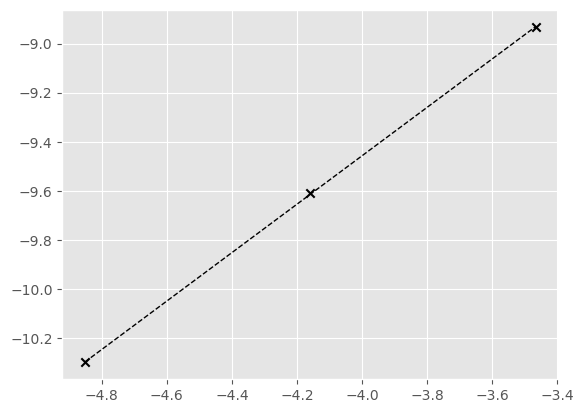

In [23]:
error = []
for i in range(len(dt)-1):
    error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)

## Crank nicholson

#### Space

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = [1/8, 1/16, 1/32, 1/64]
dt = 1/64

V_pred = []
for i, dx_i in enumerate(dx):
    S, V = lcp.solve(put, r, sigma, dx=dx_i, dt=dt, delta=delta, theta=0.5)
    V_pred.append(V[:])

[0.003766377551211425, 0.0007838328166869385, 0.0002898300872063442]
[ 1.84994918 -1.83057582]


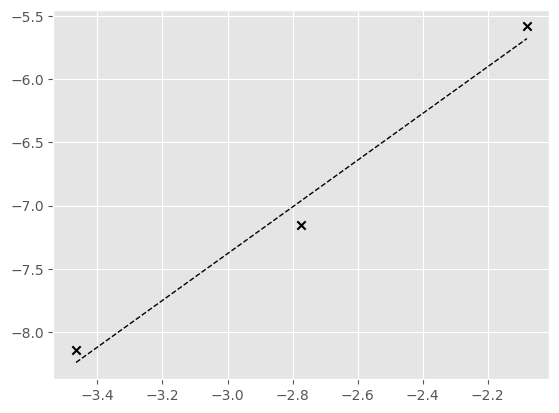

In [25]:
error = []
for i in range(len(dx)-1):
    error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
print(error)
log_error = np.log(error)
log_dx = np.log(dx[:-1])
plt.scatter(log_dx, np.log(error), marker='x', color='black')
p = np.polyfit(log_dx, log_error, deg=1)
f = np.poly1d(p)
log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
print(p)

#### Time

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import option
import lcp

dx = 1/16
dt = [1/16, 1/32, 1/64, 1/128]

V_pred = []
for i, dt_i in enumerate(dt):
    S, V = lcp.solve(put, r, sigma, dx=dx, dt=dt_i, delta=delta, theta=0.5)
    V_pred.append(V[:])

[ 2.14871589 -5.23255355]


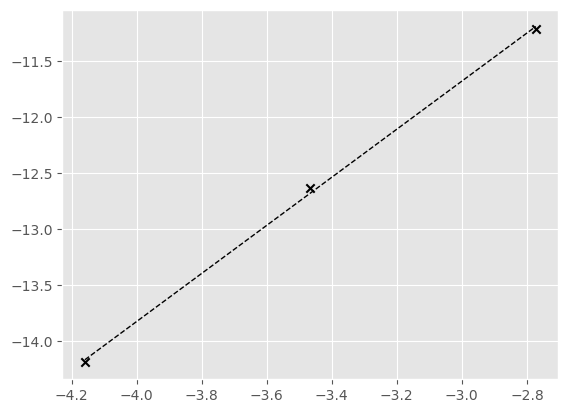

In [27]:
error = []
for i in range(len(dt)-1):
    error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
log_error = np.log(error)
log_dt = np.log(dt[:-1])
plt.scatter(log_dt, np.log(error), marker='x', color='black')
p = np.polyfit(log_dt, log_error, deg=1)
f = np.poly1d(p)
print(p)
log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)